In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline
sys.path.append("/home/pat/terliuk/software/DARWIN/DecayFitter/")

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize']=[15.0,12.0]
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.major.width']=1
plt.rcParams['xtick.minor.size']=4
plt.rcParams['xtick.minor.width']=1
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.major.width']=1
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.minor.width']=1
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelsize'] =24
plt.rcParams['legend.fontsize']= 24
plt.rcParams['legend.framealpha'] = 0.95
plt.rcParams['legend.handlelength']=2.0
plt.rcParams['figure.facecolor']="w"
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [3]:
from AnalyticCalculator import AnalyticCalculator

In [4]:
bin_edges = np.linspace(2200, 2800, 31)
#bin_edges = np.linspace(2435, 2481, 2)
ltime = 10.
calc = AnalyticCalculator(bin_edges, 
                         livetime=ltime, 
                         )

In [5]:
comps = calc.getBinnedComponents(0.0, 2.51, 1.5, 1.0, -1.05,1.42e-3 , 2.165)

In [6]:
tot = 0.
for key in comps.keys():
    tot+=np.sum(comps[key])
    print(key.ljust(15), np.sum(comps[key])/(calc.fidMass*calc.livetime*(bin_edges[-1] - bin_edges[0]) ) )

137Xe           0.0013659840000000002
222Rn           0.00029627600000000005
8B              0.000236
208Tl           0.004616282083344156
214Bi           0.0007047517048030086
44Sc            4.8167907534740406e-05
136Xe_2vbb      0.019745229663790945
136Xe_0vbb      0.0


In [7]:
#comps['136Xe_0vbb']/5/10/0.9/0.76

In [8]:
from BinnedFitter import BinnedFitter

In [9]:
fitter = BinnedFitter(loader = calc)

In [10]:
inject_values = {"AXe136": 0.0, 
                 "Scale208Tl" : 2.511,
                 "Norm214Bi" : 1.0,
                 "NormCont" : 1.0,
                 "ContSlope" : -1.2,
                 "Scale137Xe" : 1.42e-3, 
                 "T12_136Xe_2vbb" : 2.165
                }
histogram = fitter.getExpectation(**inject_values)
fitpriors_default = {"Scale208Tl" : [2.511, 0.082],  
                     "Norm214Bi"  : [1.0, 0.036],
                     "NormCont"   : [1.0, 0.036],
                     "ContSlope"  : [-1.2, 10.0],
                     "Scale137Xe" : [1.42e-3, 0.17e-3 ],
                     "T12_136Xe_2vbb" : [2.165, 0.063]
                        }
def_fvals = {"AXe136": [0.1, False], 
            "Scale208Tl" : [ 3.0, False],
            "Norm214Bi" : [1.1, False], 
            "NormCont" : [1.2, False],
            "ContSlope" : [-1., False],
            "Scale137Xe" : [1.5e-3, False],
            "T12_136Xe_2vbb" : [2.1, False]
           }

In [11]:
def get_settings_priors(case = "real"):
    cur_fvals = deepcopy(def_fvals)
    cur_priors = deepcopy(fitpriors_default)
    if case =="ideal":
        for key in cur_priors.keys():
            cur_priors[key] = [inject_values[key], 1e-8*inject_values[key] ]
    elif case =="real":
        pass
    elif "fix:" in case:
        variables = case.split("fix:")[-1]
        variables = variables.split(",")
        print("Fixing : ",  variables)
        for var in variables:
            cur_fvals[var] = [inject_values[var], True ]     
    elif "reducesigma:" in case: 
        reduceinfo = case.split("reducesigma:")[-1]
        reduceinfovars = reduceinfo.split(",")
        #print(reduceinfovars)
        for rline in reduceinfovars:
            tmpinf = rline.split("=")
            var = tmpinf[0]
            factor = float(tmpinf[1])
            print("%s reducing sigma by factor %0.2f"%(var, factor))
            cur_priors[var][1]=cur_priors[var][1]/factor
    else : 
        print("Error! Unknown confuration!")
        return None
    return cur_fvals, cur_priors

In [15]:
Scan_AXe136  = np.linspace(0,1,101)
LLHs = {}
globalfits = {}

cases = ["real", "ideal",
         "fix:Norm214Bi,NormCont,ContSlope,Scale137Xe,T12_136Xe_2vbb"] 

for case in cases:
    LLHs[case] = np.nan*np.ones_like(Scan_AXe136)
    print("Doing case : ", case)
    cur_fsettings, cur_fpriors = get_settings_priors(case)
    print(cur_fsettings)
    globalfits[case] = fitter.FitValue(histogram = histogram, 
               fitvalues = cur_fsettings, 
               priors = cur_fpriors,
               ftol = 1e-3,
               verbosity = 1
               )
    ####
    for i in range(len(Scan_AXe136)):
        cur_fsettings["AXe136"] = [Scan_AXe136[i], True]
        cur_fit_res = fitter.FitValue(
            histogram = histogram, 
               fitvalues = cur_fsettings, 
               priors = cur_fpriors,
               ftol = 1e-3,
               verbosity = 0
               )
        LLHs[case][i] =cur_fit_res['LLH']
    #values[case] = {}

Doing case :  real
{'AXe136': [0.1, False], 'Scale208Tl': [3.0, False], 'Norm214Bi': [1.1, False], 'NormCont': [1.2, False], 'ContSlope': [-1.0, False], 'Scale137Xe': [0.0015, False], 'T12_136Xe_2vbb': [2.1, False]}
---------- Boundaries ----------
AXe136         in  (0.0, inf) 
Scale208Tl     in  (0.0, inf) 
Norm214Bi      in  (0.0, 5.0) 
NormCont       in  (0.0, 5.0) 
ContSlope      in  (-100, 100) 
Scale137Xe     in  (0.0, inf) 
T12_136Xe_2vbb in  (0.1, 3) 
------------------------------
---------- Starting values: ----------
AXe136         = 0.10000 , is fixed False
Scale208Tl     = 3.00000 , is fixed False
Norm214Bi      = 1.10000 , is fixed False
NormCont       = 1.20000 , is fixed False
ContSlope      = -1.00000 , is fixed False
Scale137Xe     = 0.00150 , is fixed False
T12_136Xe_2vbb = 2.10000 , is fixed False
------------------------------
---------- Prior information ----------
Variable               mean       sigma
Scale208Tl         2.51100     0.08200
Norm214Bi          1

Text(0.48, 0.77, 'Energies : [ 2200.0, 2800.0 ], 30 bins')

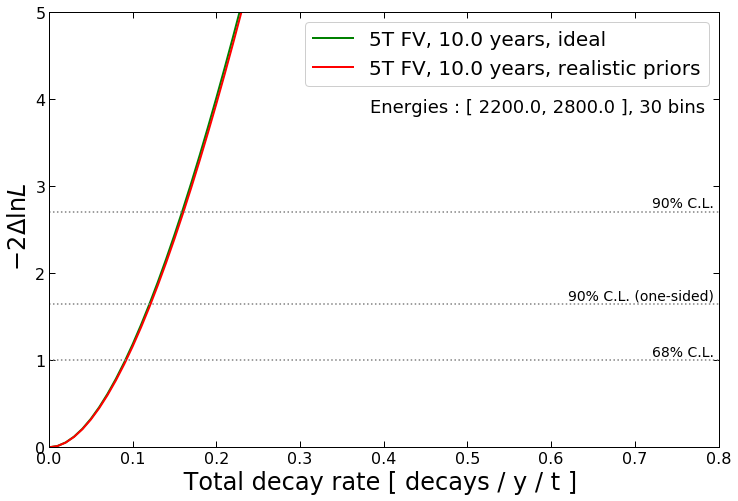

In [27]:
# And plotting the scan 
fig = plt.figure(figsize = (12,8))
ax= fig.add_subplot(111)
ax.plot(Scan_AXe136 , 2.0 * (LLHs["ideal"]  - globalfits["ideal"]['LLH']), lw=2, c = "g", label = "5T FV, %0.1f years, ideal"%ltime )
ax.plot(Scan_AXe136 , 2.0 * (LLHs["real"]  - globalfits["real"]['LLH']), lw=2, c = "r", label = "5T FV, %0.1f years, realistic priors"%ltime )

plt.axhline(1.0, c= "0.5", ls =":")
plt.axhline(2.71, c= "0.5", ls =":")

#ax.set_xscale("log")
ax.set_ylim(0, 5)
ax.set_xlim(0, 0.8)
ax.set_ylabel(r" $ - 2 \Delta \ln L $")
ax.set_xlabel(r" Total decay rate [ decays / y / t ]  ")
ax.legend(fontsize=20)
ax.text(0.72, 1.05, "68% C.L. ", fontsize=14)
ax.text(0.72, 2.76, "90% C.L. ", fontsize=14)
plt.axhline(1.643, c= "0.5", ls =":")
ax.text(0.62, 1.694, "90% C.L. (one-sided)", fontsize=14)


erange = "[ %0.1f, %0.1f ]"%(bin_edges[0], bin_edges[-1])
erange += ", %d bin"%(len(bin_edges)-1)
if (len(bin_edges)-1)>1: erange+="s"
ax.text(0.48,0.77, "Energies : "+erange, transform=ax.transAxes, fontsize=18)
#fig.savefig("/home/pat/terliuk/science/DARWIN/0vbb_sens/DARWIN_5t_10y_sens_decay_2200_2800.png", dpi=300)
#fig.savefig("/home/pat/terliuk/science/DARWIN/0vbb_sens/DARWIN_5t_10y_sens_decay_2200_2800.pdf", dpi=300)

/misc/home/pat/terliuk/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


Text(0.48, 0.8, 'Energies : [ 2200.0, 2800.0 ], 30 bins')

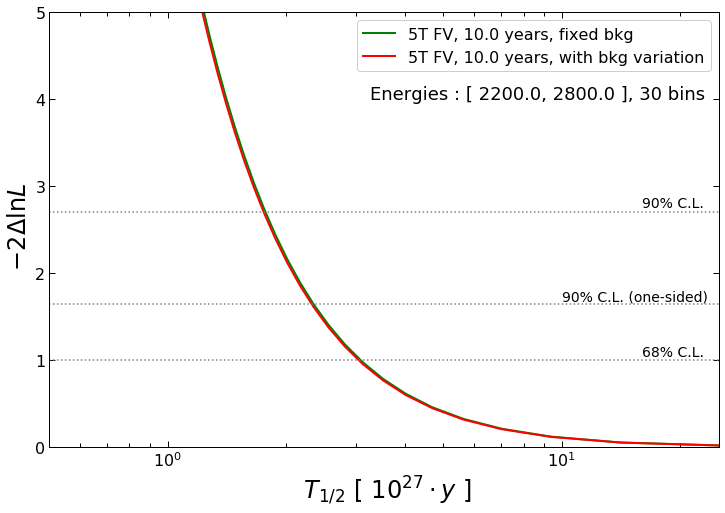

In [20]:
# we can also plot it as a function of half life 
# For this, we need to convert it using the formula 
# T_{1/2} = ln(2) / A * abundance * N_A / M_Xe
# With numbers plugged in 
# np.log(2)*6.0214/131.293*8.8573 = 0.28157 
# T_{1/2} [10^{27} y ] \approx  0.28157 / A [ ev / y / t ] 
T_1_2 = 0.28157 / Scan_AXe136


fig = plt.figure(figsize = (12,8), facecolor="w")
ax= fig.add_subplot(111)
ax.plot(T_1_2 , 2.0 * (LLHs["ideal"]  - globalfits[case]['LLH']), lw=2, c = "g", label = "5T FV, %0.1f years, fixed bkg"%ltime )
ax.plot(T_1_2 , 2.0 * (LLHs["real"]  - globalfits[case]['LLH']), lw=2, c = "r", label = "5T FV, %0.1f years, with bkg variation"%ltime )
for key in []:#LLHs.keys():
    #if key in ['real', 'ideal']: continue
    if "fix" not in key: continue
    ax.plot(T_1_2 , 2.0 * (LLHs[key]  - globalfits[key]['LLH']), 
            lw=2, ls="--", label = key )

plt.axhline(1.0, c= "0.5", ls =":")
ax.text(16.0, 1.05, "68% C.L. ", fontsize=14)

plt.axhline(1.643, c= "0.5", ls =":")
ax.text(10.0, 1.69, "90% C.L. (one-sided)", fontsize=14)

plt.axhline(2.71, c= "0.5", ls =":")
ax.text(16.0, 2.76, "90% C.L. ", fontsize=14)
ax.legend(fontsize=16)

ax.set_xscale("log")
ax.set_ylim(0, 5)
ax.set_xlim(0.5, 25)
ax.set_ylabel(r" $ - 2 \Delta \ln L $")
ax.set_xlabel(r" $T_{1/2}\ [\ 10^{27} \cdot y\ ] $")
ax.text(0.48,0.8, "Energies : "+erange, transform=ax.transAxes, fontsize=18)

#fig.savefig("/home/pat/terliuk/science/DARWIN/0vbb_sens/DARWIN_5t_10y_sens_T12_2200_2800.png", dpi=300)
#fig.savefig("/home/pat/terliuk/science/DARWIN/0vbb_sens/DARWIN_5t_10y_sens_T12_2200_2800.pdf", dpi=300)

In [21]:
from scipy.interpolate import interp1d
from scipy.optimize import root
limits = {}
limit_results = {}
for case in globalfits.keys():
    # Creating spline 
    critical_value = 1.643 # This is critical value for xi^2 with 1 dof for 90% C.L. 
    doubleLLH_profile = interp1d(T_1_2[1:], 2.0 * (LLHs[case] - globalfits[case]['LLH'])[1:], kind="cubic") 
    halflife_result =  root(lambda x: doubleLLH_profile(x) - critical_value, 1.0 ) 
    #print(halflife_result)
    limit_results[case]=halflife_result
    limits[case]=halflife_result['x']

In [22]:
limits

{'real': array([2.32217545]),
 'ideal': array([2.34876274]),
 'fix:Norm214Bi,NormCont,ContSlope,Scale137Xe,T12_136Xe_2vbb': array([2.34635221])}

In [ ]:
{'real': array([2.17011671]),
 'ideal': array([2.18533365]),
 'fix:Norm214Bi,NormCont,ContSlope,Scale137Xe,T12_136Xe_2vbb': array([2.18355603])}